In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Import libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [6]:
# Load the dataset
cambridge_data = pd.read_csv('parker_street.csv')

In [7]:
# Load the dataset
cam_weather_data = pd.read_csv('cambridge_weather.csv')

# Data Cleaning and Preprocessing

In [8]:
# Display the first few rows of the dataset
cambridge_data.head()

,End Date,End Time,NO2 (ugm-3)
0,1/1/2020,1:00:00,29.89503
1,1/1/2020,2:00:00,40.41496
2,1/1/2020,3:00:00,34.57873
3,1/1/2020,4:00:00,30.37369
4,1/1/2020,5:00:00,30.91166


The cambridge_data contains the following columns:

- End Date: The date of the observation.
- End Time: The hour of the observation.
- NO2 (ugm-3): The concentration of NO2 pollutant.

In [9]:
cambridge_data.describe()

,NO2 (ugm-3)
count,30212.000000
mean,23.602041
std,14.253588
min,0.251880
25%,11.997782
50%,21.340610
75%,32.985450
max,104.383910


In [10]:
cambridge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31391 entries, 0 to 31390
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   End Date     31391 non-null  object 
 1   End Time     31391 non-null  object 
 2   NO2 (ugm-3)  30212 non-null  float64
dtypes: float64(1), object(2)
memory usage: 735.9+ KB


In [11]:
# Check for missing values
cambridge_data.isnull().sum()

End Date          0
End Time          0
NO2 (ugm-3)    1179
dtype: int64

There are 1179 missing values. This is compared to a total observation of 8808. Since we are dealing with timeseries data, we will use interpolation to estimate the missing values, as it will provide a smoother transition between data points with minimal impact on our timeseries analysis.

In [12]:
# Interpolate missing values
cambridge_data['NO2 (ugm-3)'].interpolate(method='linear', inplace=True)

In [13]:
cambridge_data.isnull().sum()

End Date       0
End Time       0
NO2 (ugm-3)    0
dtype: int64

All missing values have been replaced using the interpolate method

In [14]:
cam_weather_data.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,cambridge,2020-01-01T00:00:00,7.0,5.0,5.8,91.66,0.0,0,NaN,0.0,...,1031.2,95.3,5.6,0.0,0.0,0,NaN,Overcast,cloudy,"358,303,503,403,680,000,000,000,000,000,000,00..."
1,cambridge,2020-01-01T01:00:00,6.6,3.7,4.9,88.83,0.0,0,NaN,0.0,...,1030.6,60.4,5.7,0.0,0.0,0,NaN,Partially cloudy,partly-cloudy-night,"35,830,350,340,368,000,000,000,000,000,000,000..."
2,cambridge,2020-01-01T02:00:00,5.8,2.9,4.6,92.54,0.0,0,NaN,0.0,...,1030.2,97.9,5.0,0.0,0.0,0,NaN,Overcast,cloudy,"35,830,350,340,368,000,000,000,000,000,000,000..."
3,cambridge,2020-01-01T03:00:00,6.1,3.6,4.9,91.64,0.0,0,NaN,0.0,...,1030.1,96.3,4.9,0.0,0.0,0,NaN,Overcast,cloudy,"35,830,350,340,368,000,000,000,000,000,000,000..."
4,cambridge,2020-01-01T04:00:00,5.8,3.0,4.4,90.65,0.0,0,NaN,0.0,...,1029.8,100.0,4.9,0.0,0.0,0,NaN,Overcast,cloudy,"35,830,350,340,368,000,000,000,000,000,000,000..."


In [15]:
cam_weather_data.describe()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,31391.000000,31391.000000,31391.000000,31391.000000,31391.000000,31391.000000,31391.000000,31391.000000,16411.000000,31391.000000,31391.000000,31330.000000,31391.000000,31391.000000,31391.000000,31391.000000,31391.000000,13619.000000
mean,10.887261,9.663388,7.272320,80.775303,0.071579,15.341977,0.000988,0.056325,14.805210,9.456905,190.970243,1015.406684,54.630572,12.870756,120.754086,0.433315,1.185977,9.994566
std,6.313062,7.472950,4.880778,16.574023,0.551829,36.039739,0.050102,0.651788,8.176217,5.162279,95.543623,11.217939,33.551827,5.641787,196.221643,0.707960,1.984475,1.154709
min,-6.900000,-11.700000,-12.100000,17.560000,0.000000,0.000000,0.000000,0.000000,1.100000,0.000000,1.000000,970.900000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,6.400000,3.800000,3.800000,70.845000,0.000000,0.000000,0.000000,0.000000,8.700000,5.700000,118.000000,1008.500000,24.800000,8.800000,0.000000,0.000000,0.000000,10.000000
50%,10.600000,10.600000,7.600000,86.470000,0.000000,0.000000,0.000000,0.000000,12.900000,8.600000,212.000000,1016.400000,56.600000,13.200000,12.000000,0.000000,0.000000,10.000000
75%,15.200000,15.200000,10.900000,93.990000,0.000000,0.000000,0.000000,0.000000,19.400000,12.500000,257.000000,1023.100000,87.800000,16.800000,169.000000,0.600000,2.000000,10.000000
max,38.200000,36.400000,20.100000,100.000000,47.690000,100.000000,7.010000,14.950000,61.200000,43.400000,360.000000,1048.800000,100.000000,43.000000,1150.000000,4.100000,10.000000,30.000000


In [16]:
cam_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31391 entries, 0 to 31390
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              31391 non-null  object 
 1   datetime          31391 non-null  object 
 2   temp              31391 non-null  float64
 3   feelslike         31391 non-null  float64
 4   dew               31391 non-null  float64
 5   humidity          31391 non-null  float64
 6   precip            31391 non-null  float64
 7   precipprob        31391 non-null  int64  
 8   preciptype        5690 non-null   object 
 9   snow              31391 non-null  float64
 10  snowdepth         31391 non-null  float64
 11  windgust          16411 non-null  float64
 12  windspeed         31391 non-null  float64
 13  winddir           31391 non-null  float64
 14  sealevelpressure  31330 non-null  float64
 15  cloudcover        31391 non-null  float64
 16  visibility        31391 non-null  float6

In [17]:
cam_weather_data.nunique()

name                    1
datetime            31388
temp                  409
feelslike             439
dew                   292
humidity             6119
precip               1207
precipprob              2
preciptype              3
snow                   11
snowdepth             190
windgust              451
windspeed             333
winddir               370
sealevelpressure      730
cloudcover            973
visibility            357
solarradiation       1092
solarenergy            42
uvindex                11
severerisk              4
conditions             11
icon                    9
stations              248
dtype: int64

In [18]:
# Check for missing values
cam_weather_data.isnull().sum()

name                    0
datetime                0
temp                    0
feelslike               0
dew                     0
humidity                0
precip                  0
precipprob              0
preciptype          25701
snow                    0
snowdepth               0
windgust            14980
windspeed               0
winddir                 0
sealevelpressure       61
cloudcover              0
visibility              0
solarradiation          0
solarenergy             0
uvindex                 0
severerisk          17772
conditions              0
icon                    0
stations                0
dtype: int64

### NO2 Data

In [19]:
def cambridge_data_feature_eng(df):

    # Fill Null values with mean of it respective feature
    df.fillna(df.mean(), inplace=True)

    # Convert 'End Date' to datetime format
    df['End Date'] = pd.to_datetime(df['End Date'], format='%d/%m/%Y')

    # Adjust for entries where 'End Time' is "24:00:00"
    time_locator = df['End Time'] == "24:00:00"
    df.loc[time_locator, 'End Date'] += pd.Timedelta(days=1)
    df.loc[time_locator, 'End Time'] = "00:00:00"

    # Combine 'End Date' and 'End Time' to create 'Datetime' column
    df['datetime'] = df['End Date'] + pd.to_timedelta(df['End Time'])

    # Drop 'End Date' and 'End Time'
    df.drop(columns=['End Date', 'End Time'], inplace=True)

    # Set 'Datetime' as the index
    df.set_index('datetime', inplace=True)

    return df

In [20]:
cambridge_data = cambridge_data_feature_eng(cambridge_data)

In [21]:
cambridge_data.head()

,NO2 (ugm-3)
datetime,
2020-01-01 01:00:00,29.89503
2020-01-01 02:00:00,40.41496
2020-01-01 03:00:00,34.57873
2020-01-01 04:00:00,30.37369
2020-01-01 05:00:00,30.91166


### Weather Data

In [22]:
def cambridge_weather_feature_eng(df):

    # Drop columns with high null values and columns with no impact on the analysis
    df.drop(columns=['name','preciptype','windgust','severerisk','stations'], axis=1, inplace=True)

    # Fill Null values with mean of it respective feature
    df.fillna(df.mean(), inplace=True)

    # Convert 'datetime' to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Set 'Datetime' as the index
    df.set_index('datetime', inplace=True)

    return df

In [23]:
cam_weather_data = cambridge_weather_feature_eng(cam_weather_data)

In [24]:
cam_weather_data.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon
datetime,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7.0,5.0,5.8,91.66,0.0,0,0.0,0.0,6.6,95.0,1031.2,95.3,5.6,0.0,0.0,0,Overcast,cloudy
2020-01-01 01:00:00,6.6,3.7,4.9,88.83,0.0,0,0.0,0.0,9.7,111.0,1030.6,60.4,5.7,0.0,0.0,0,Partially cloudy,partly-cloudy-night
2020-01-01 02:00:00,5.8,2.9,4.6,92.54,0.0,0,0.0,0.0,8.4,119.0,1030.2,97.9,5.0,0.0,0.0,0,Overcast,cloudy
2020-01-01 03:00:00,6.1,3.6,4.9,91.64,0.0,0,0.0,0.0,7.6,147.0,1030.1,96.3,4.9,0.0,0.0,0,Overcast,cloudy
2020-01-01 04:00:00,5.8,3.0,4.4,90.65,0.0,0,0.0,0.0,8.0,148.0,1029.8,100.0,4.9,0.0,0.0,0,Overcast,cloudy


### Merged NO2 and Weather Data

In [25]:
def merged_feature_eng(df1, df2):

    # Merge the dataframes
    df = pd.merge(df1, df2, on='datetime', how='inner')

    #create hour, day and month variables from datetime index
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month

    return df

In [26]:
merged_df = merged_feature_eng(cam_weather_data, cambridge_data)

In [27]:
merged_df.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,...,visibility,solarradiation,solarenergy,uvindex,conditions,icon,NO2 (ugm-3),hour,day,month
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,6.6,3.7,4.9,88.83,0.0,0,0.0,0.0,9.7,111.0,...,5.7,0.0,0.0,0,Partially cloudy,partly-cloudy-night,29.89503,1,1,1
2020-01-01 02:00:00,5.8,2.9,4.6,92.54,0.0,0,0.0,0.0,8.4,119.0,...,5.0,0.0,0.0,0,Overcast,cloudy,40.41496,2,1,1
2020-01-01 03:00:00,6.1,3.6,4.9,91.64,0.0,0,0.0,0.0,7.6,147.0,...,4.9,0.0,0.0,0,Overcast,cloudy,34.57873,3,1,1
2020-01-01 04:00:00,5.8,3.0,4.4,90.65,0.0,0,0.0,0.0,8.0,148.0,...,4.9,0.0,0.0,0,Overcast,cloudy,30.37369,4,1,1
2020-01-01 05:00:00,4.9,2.5,3.5,90.94,0.0,0,0.0,0.0,6.4,161.0,...,4.0,0.0,0.0,0,Partially cloudy,partly-cloudy-night,30.91166,5,1,1


# Exploratory Data Analysis (EDA)

### Univariate Distributions

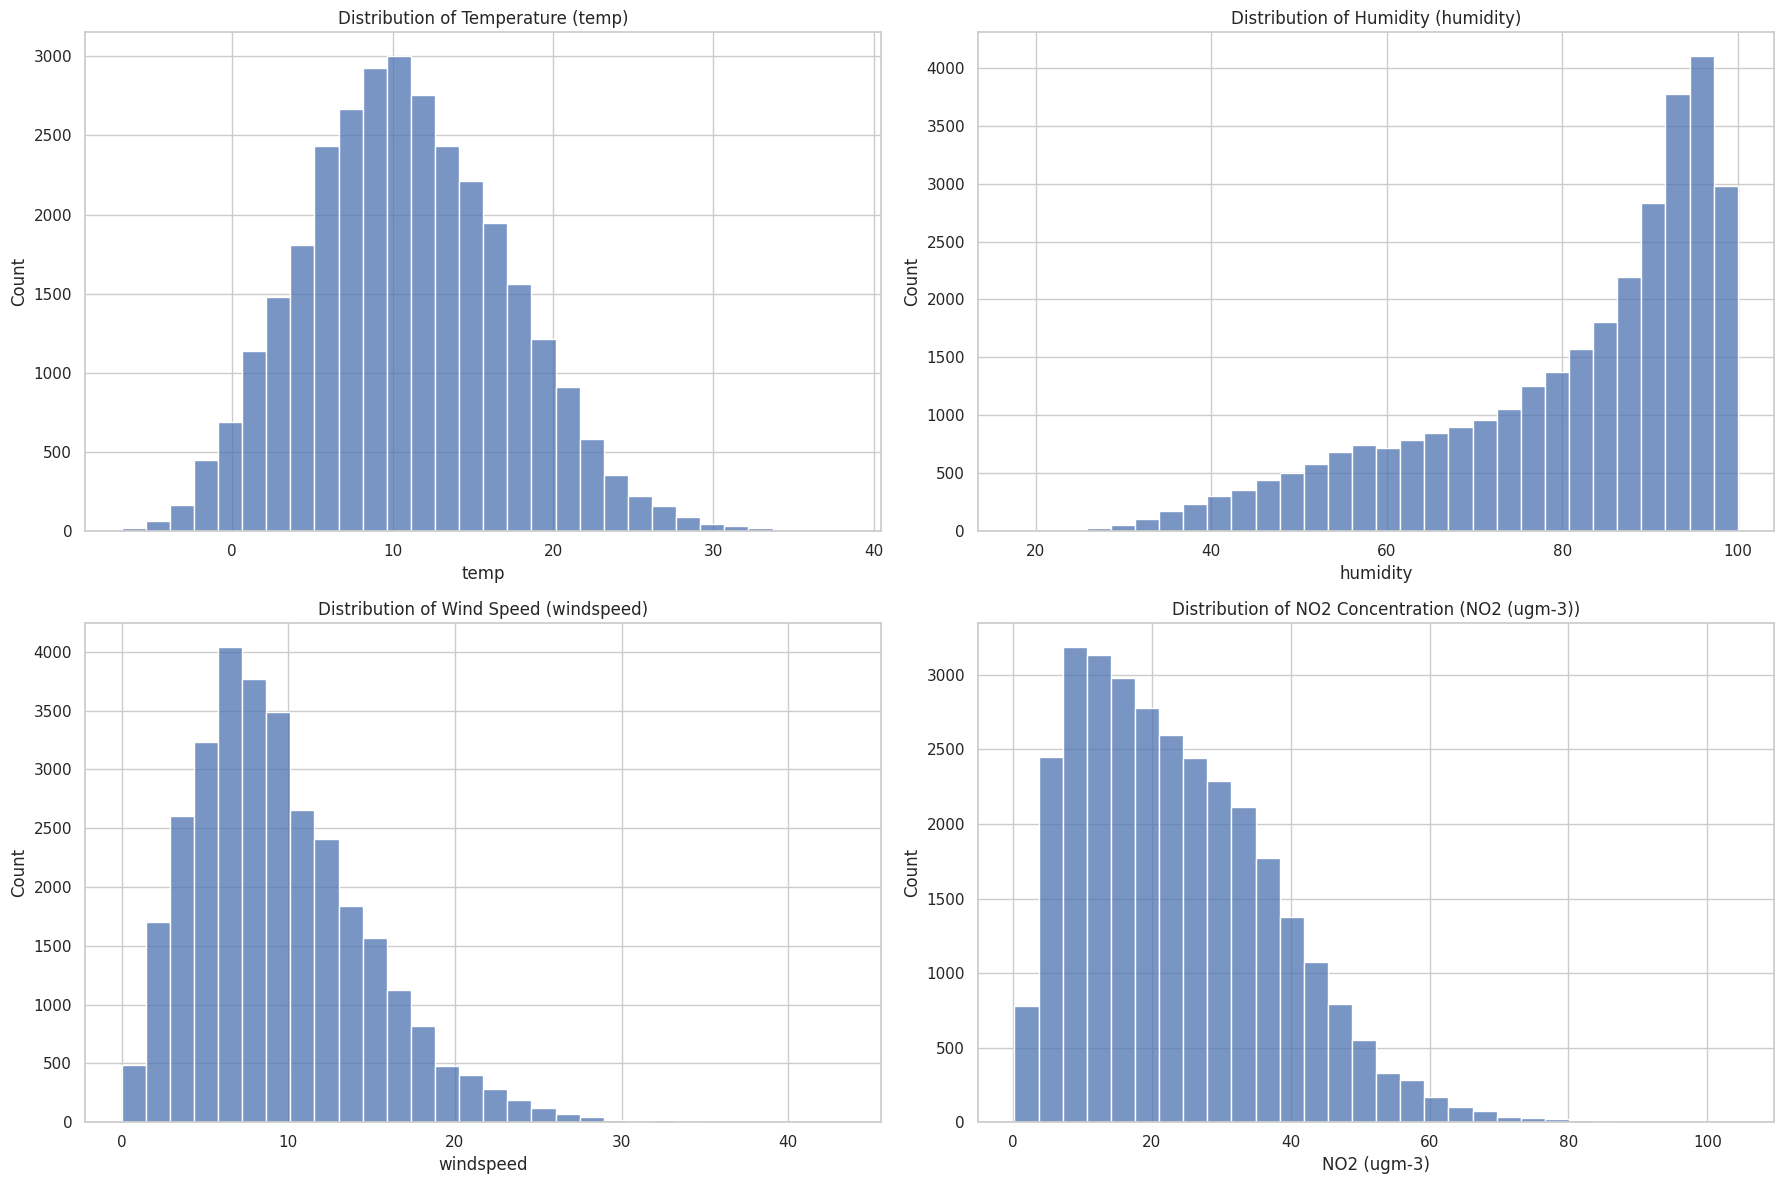

In [28]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot univariate distributions
sns.histplot(merged_df['temp'], bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Temperature (temp)')

sns.histplot(merged_df['humidity'], bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Humidity (humidity)')

sns.histplot(merged_df['windspeed'], bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Wind Speed (windspeed)')

sns.histplot(merged_df['NO2 (ugm-3)'], bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of NO2 Concentration (NO2 (ugm-3))')

plt.tight_layout()
plt.show()


### Time series trends for temp and NO2

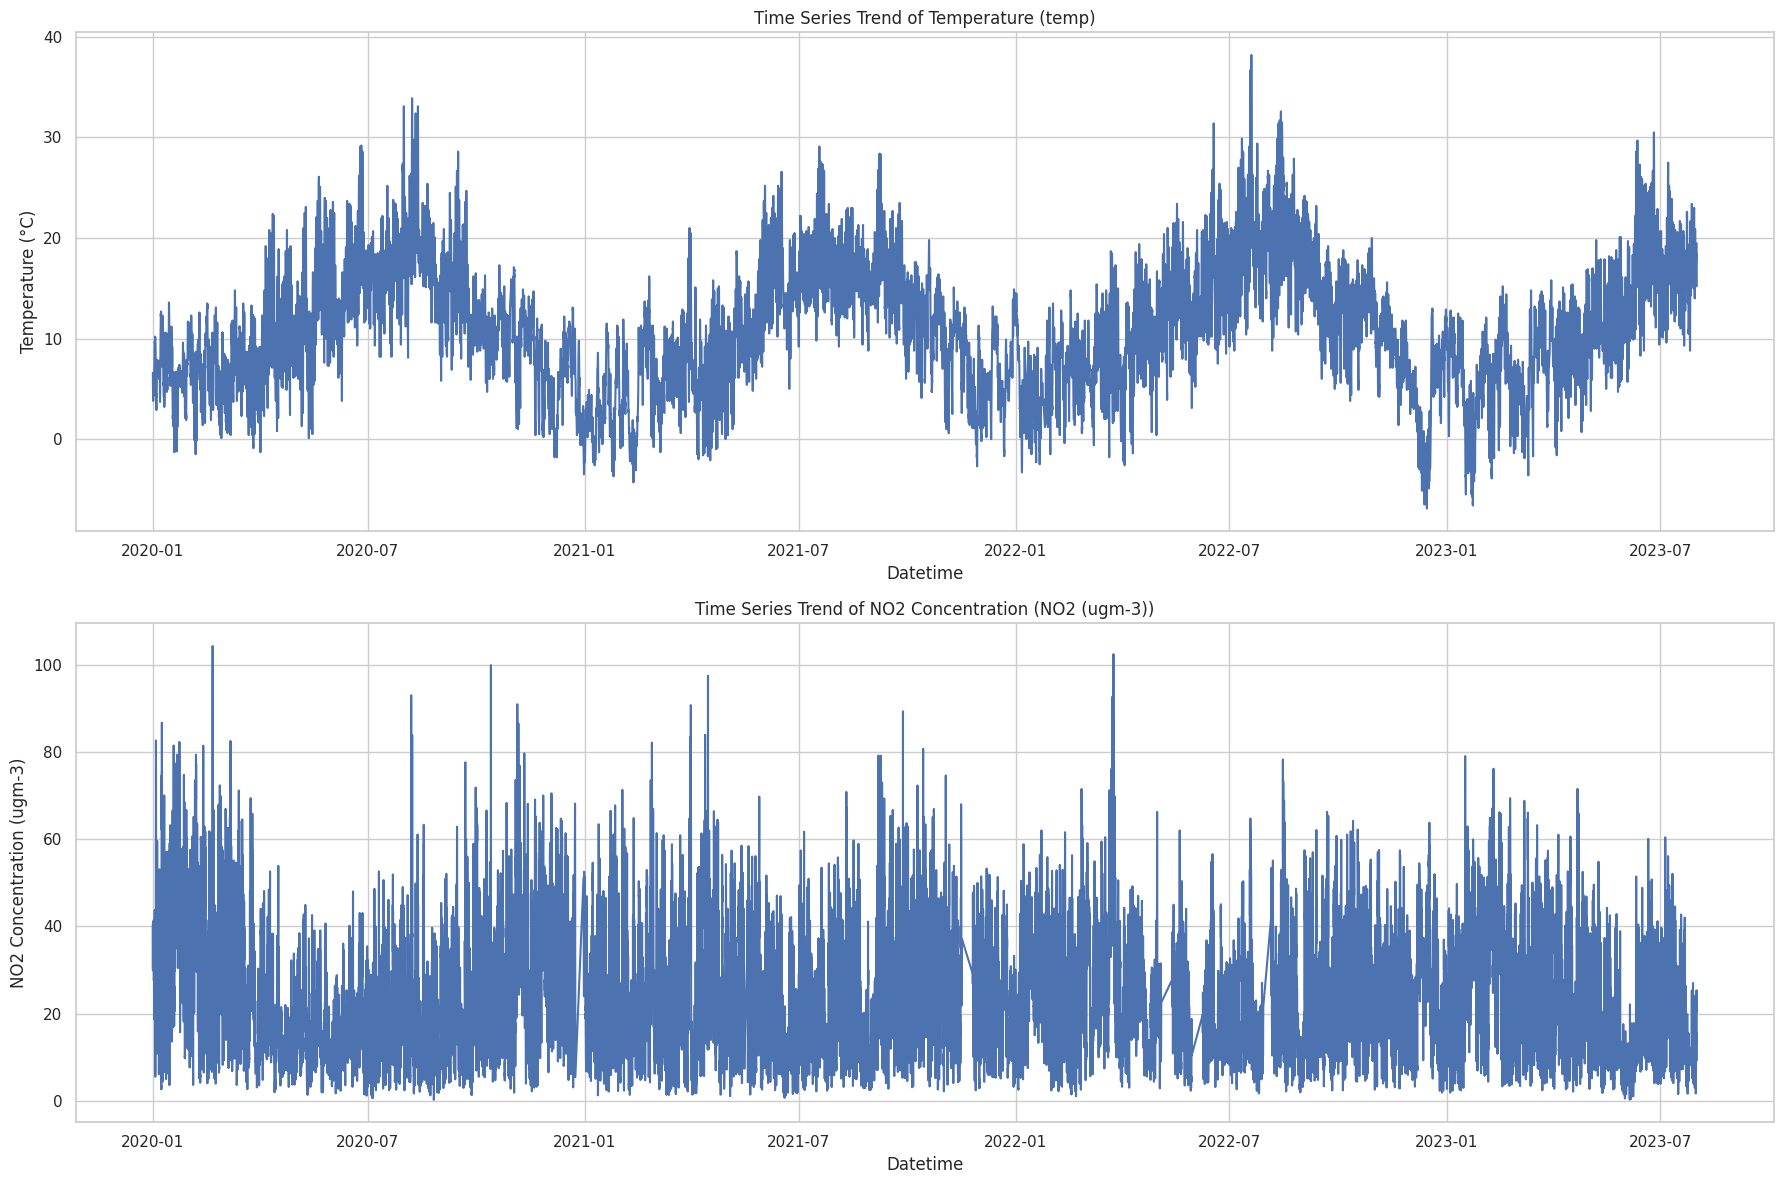

In [29]:
# Create subplots for time series trends
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Plotting time series trends for 'temp' and 'NO2 (ugm-3)'
sns.lineplot(x='datetime', y='temp', data=merged_df, ax=axes[0])
axes[0].set_title('Time Series Trend of Temperature (temp)')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Temperature (°C)')

sns.lineplot(x='datetime', y='NO2 (ugm-3)', data=merged_df, ax=axes[1])
axes[1].set_title('Time Series Trend of NO2 Concentration (NO2 (ugm-3))')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('NO2 Concentration (ugm-3)')

plt.tight_layout()
plt.show()

### Distribution of categorical variables conditions and icon

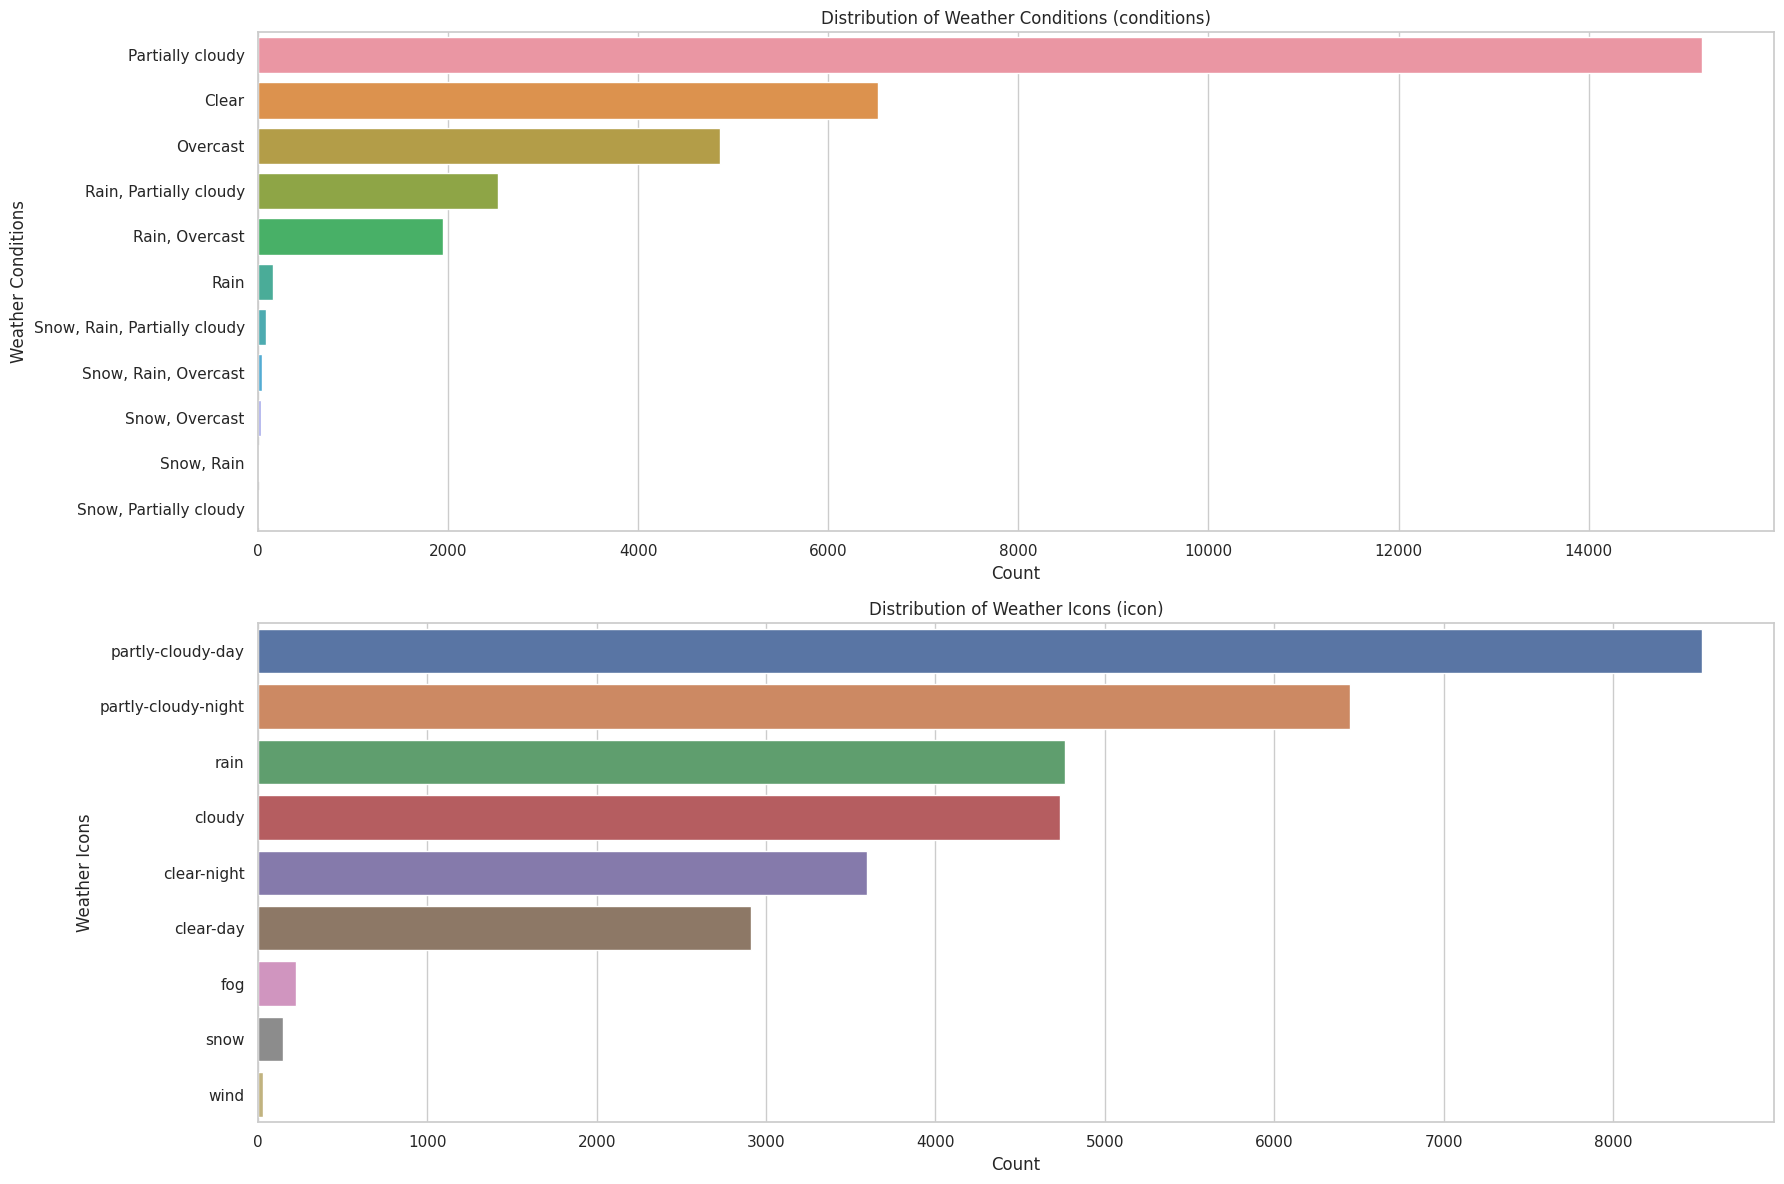

In [30]:
# Create subplots for categorical variables
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Plotting the distribution of 'conditions' and 'icon'
sns.countplot(y='conditions', data=merged_df, ax=axes[0], order=merged_df['conditions'].value_counts().index)
axes[0].set_title('Distribution of Weather Conditions (conditions)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Weather Conditions')

sns.countplot(y='icon', data=merged_df, ax=axes[1], order=merged_df['icon'].value_counts().index)
axes[1].set_title('Distribution of Weather Icons (icon)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Weather Icons')

plt.tight_layout()
plt.show()

### Time Series Decomposition of NO2

In [31]:
def decompose_NO2(df, share_type='NO2 (ugm-3)', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()

    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

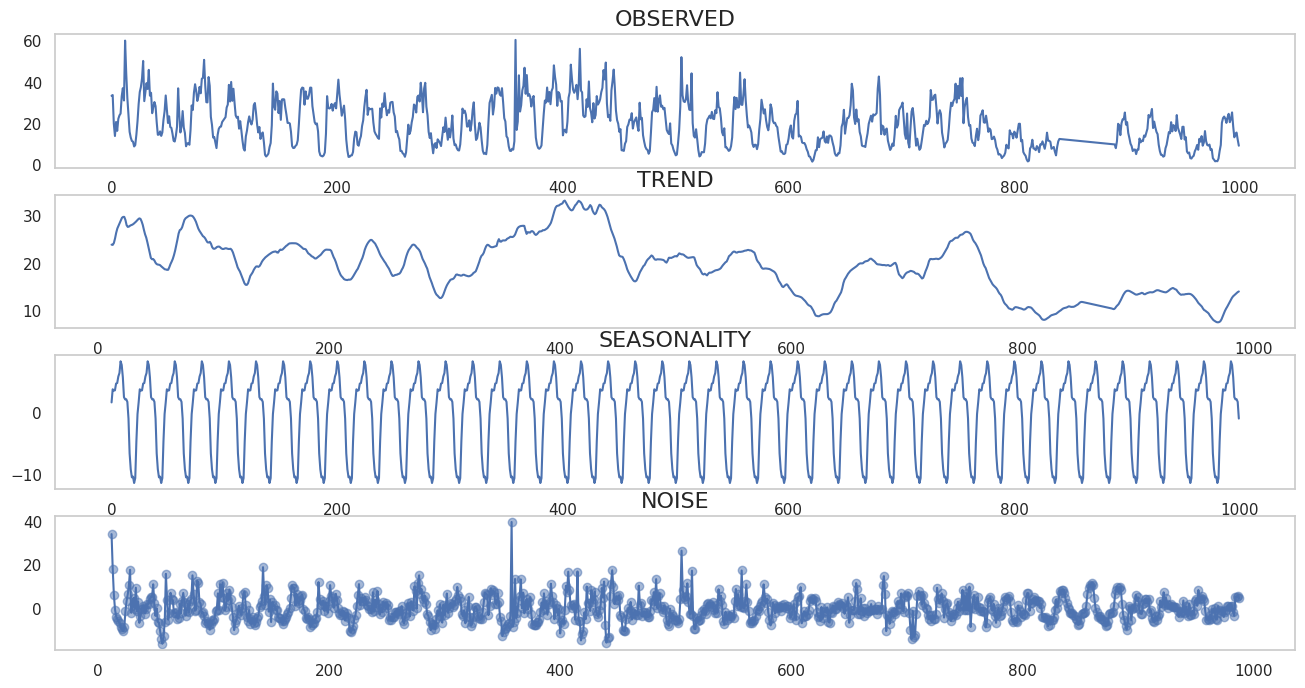

In [32]:
decompose_NO2(cambridge_data, samples=1000, period=24)

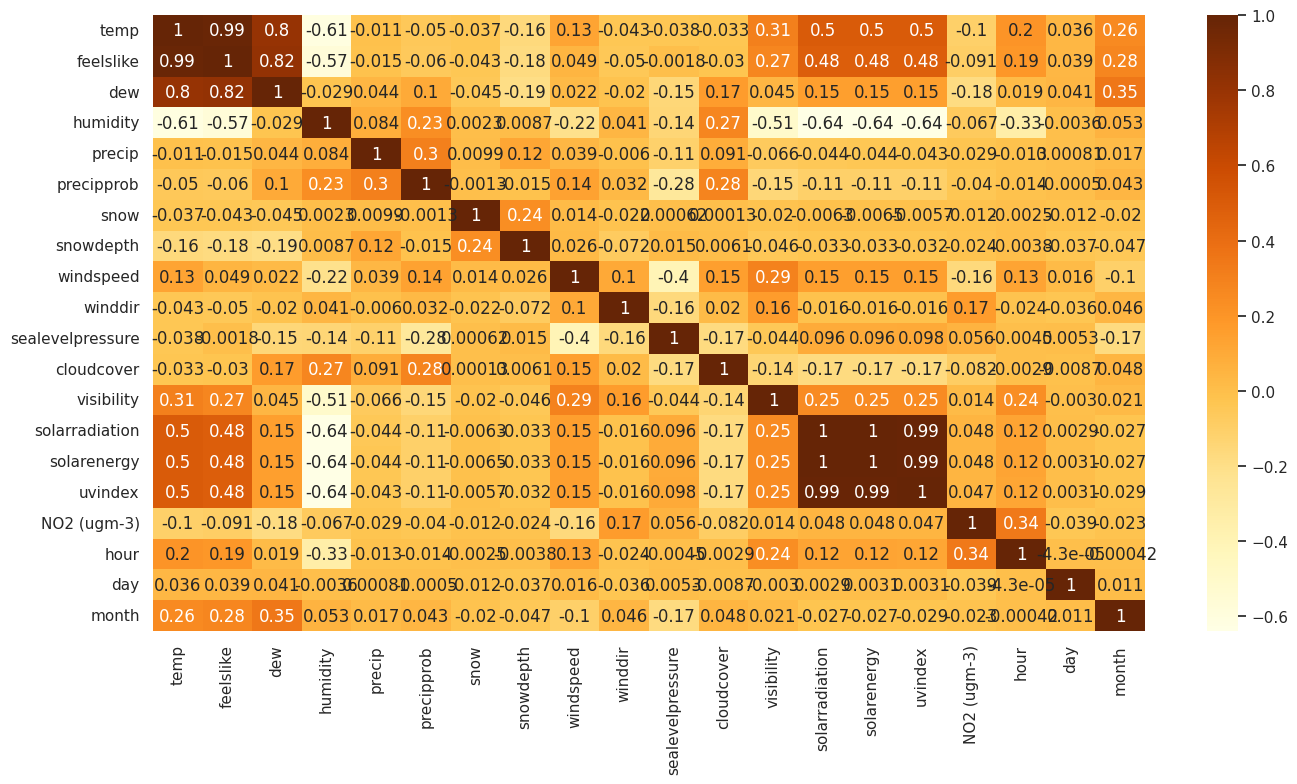

In [33]:
# Correlation Martix and Heatmap
correlations = merged_df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlations, annot=True, cmap='YlOrBr')
plt.show()

# Feature Selection and Engineering

In [34]:
# Perform one-hot encoding for the categorical variables
merged_df = pd.get_dummies(merged_df, columns=['conditions', 'icon'], drop_first=True)

In [35]:
def feature_selection(df):

    # Split the data into features (X) and target (y) variables
    X = df.drop(['NO2 (ugm-3)'], axis=1)  # Exclude 'datetime' and target variable
    y = df['NO2 (ugm-3)']


    # Create Model
    rf = RandomForestRegressor(n_estimators=100, random_state=10)

    # Create recursive feature eliminator that scores features by mean squared errors
    rfecv = RFECV(estimator=rf, step=1, scoring='neg_mean_squared_error', cv=5, verbose=1)

    # Fit recursive feature eliminator
    rfecv.fit(X, y)

    # Recursive feature elimination
    rfecv.transform(X)

    # Number of best features
    print(); print(rfecv)
    print(); print(f'Optimal Number of features: {rfecv.n_features_}')
    print(); print(np.where(rfecv.support_ == True)[0])

    # Get the names of the columns from the original feature set
    original_columns = X.columns

    # Find out which columns were selected by RFE
    selected_indices = np.where(rfecv.support_ == True)[0]

    # Use these indices to get the corresponding column names
    selected_columns = original_columns[selected_indices]

    return selected_columns

In [36]:
selected_columns = feature_selection(merged_df)

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

In [37]:
# All features with correlations above or below +/-0.10 in relation to NO2 will be selected. Other features except from categorical features will be excluded from feature analysis.

In [38]:
# Select relevant features
selected_columns_names = list(selected_columns)

In [39]:
print(selected_columns_names)

['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'hour', 'day', 'month', 'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain', 'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy', 'conditions_Snow, Rain, Partially cloudy', 'icon_clear-night', 'icon_cloudy', 'icon_fog', 'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain', 'icon_snow']


In [40]:
selected_columns_names.append('NO2 (ugm-3)')

In [41]:
print(selected_columns_names)

['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'hour', 'day', 'month', 'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain', 'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy', 'conditions_Snow, Rain, Partially cloudy', 'icon_clear-night', 'icon_cloudy', 'icon_fog', 'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain', 'icon_snow', 'NO2 (ugm-3)']


In [42]:
merged_df = merged_df[selected_columns_names]

In [43]:
merged_df.head()

,temp,feelslike,dew,humidity,precip,precipprob,snowdepth,windspeed,winddir,sealevelpressure,...,"conditions_Rain, Partially cloudy","conditions_Snow, Rain, Partially cloudy",icon_clear-night,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_snow,NO2 (ugm-3)
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,6.6,3.7,4.9,88.83,0.0,0,0.0,9.7,111.0,1030.6,...,0,0,0,0,0,0,1,0,0,29.89503
2020-01-01 02:00:00,5.8,2.9,4.6,92.54,0.0,0,0.0,8.4,119.0,1030.2,...,0,0,0,1,0,0,0,0,0,40.41496
2020-01-01 03:00:00,6.1,3.6,4.9,91.64,0.0,0,0.0,7.6,147.0,1030.1,...,0,0,0,1,0,0,0,0,0,34.57873
2020-01-01 04:00:00,5.8,3.0,4.4,90.65,0.0,0,0.0,8.0,148.0,1029.8,...,0,0,0,1,0,0,0,0,0,30.37369
2020-01-01 05:00:00,4.9,2.5,3.5,90.94,0.0,0,0.0,6.4,161.0,1029.9,...,0,0,0,0,0,0,1,0,0,30.91166


# Train-Test Split


In [44]:
# horizon is one week of hourly data
horizon = 24*7

# Set X and y
X = merged_df.drop('NO2 (ugm-3)', axis=1)
y = merged_df['NO2 (ugm-3)']

# Take the last week of the dataset for validation
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

# Create a MinMaxScaler object
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Time Series Prediction

### Random Forest Regressor Model

In [45]:
def train_RandForest_Regressor(X, X_train, X_test, y_train, y_test):

    # Train model
    rf_model = RandomForestRegressor(random_state=10)
    rf_model.fit(X_train, y_train)

    # Cross-Validation to get predictions
    predict = cross_val_predict(rf_model, X_test, y_test, cv=5)

    # Plot actual vs predicted for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title("Actual vs Predicted (Random_Forest Regressor)", fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predict, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('NO2 (ugm-3)', fontsize=16)
    plt.legend(labels=['Actual', 'Predicted'], fontsize=16)
    plt.grid()
    plt.show()

    # Create a dataframe with the variable importances of the model
    df_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importance.importance, y=df_importance.feature[:10], orient='h')
    plt.show()

    # Calculate Mean Absolute Error (MAE)
    # Cross-Validation to get negative mean absolute error
    neg_mae_scores = cross_val_score(rf_model, X_test, y_test, cv=5, scoring='neg_mean_absolute_error').mean()
    # Convert negative MAE to Mean Absolute Error (MAE)
    mae = -neg_mae_scores

    # Calculate Root Mean Square Error (RMSE)
    # Cross-Validation to get negative mean squared error
    neg_mse_scores = cross_val_score(rf_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean()
    # Convert negative MSE to Root Mean Square Error (RMSE)
    rmse = np.sqrt(-neg_mse_scores)

    return mae, rmse, predict, rf_model

### Train and Predict using Random Forest Regressor Model

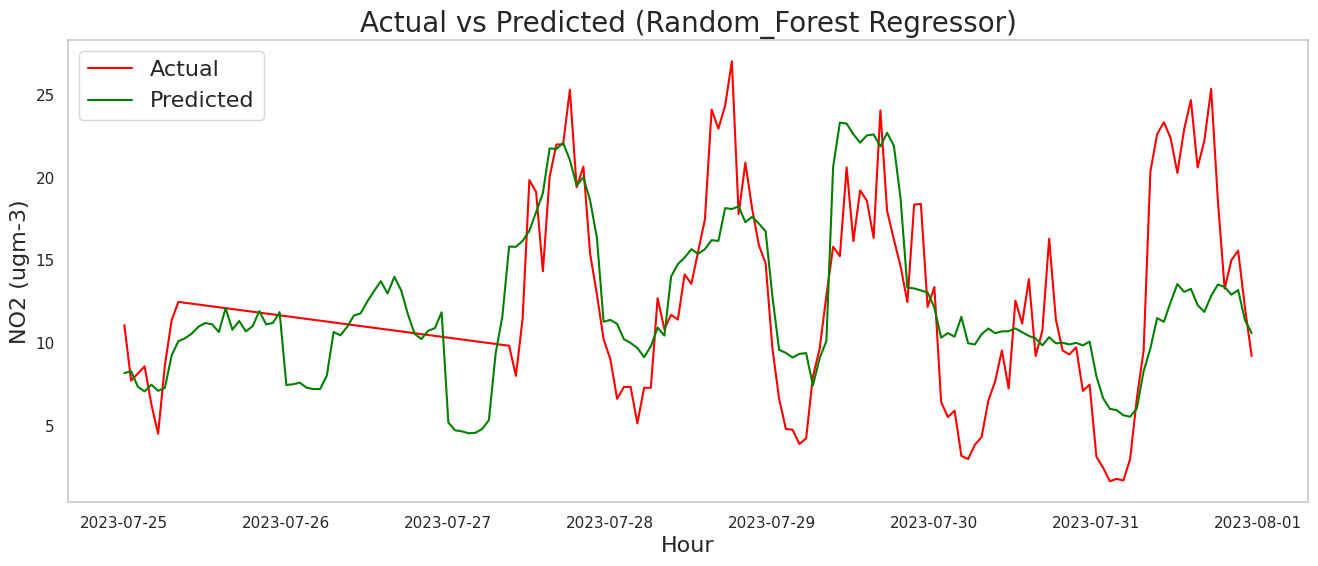

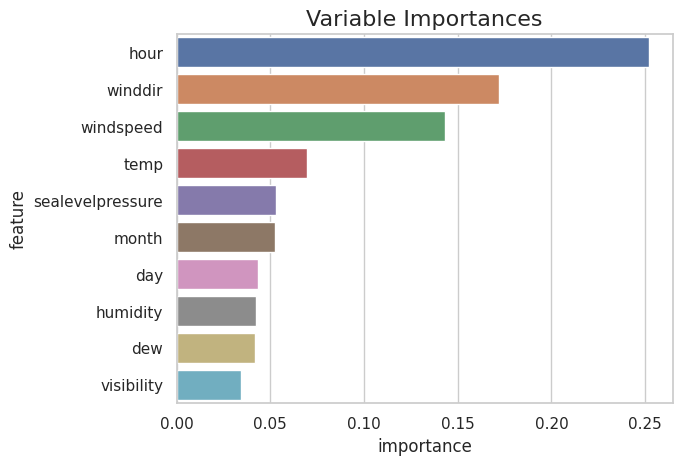

In [46]:
mae_randforest, rmse_randforest, predictions_randforest, rf_model = train_RandForest_Regressor(X, X_train, X_test, y_train, y_test)

In [47]:
print(f'Random Forest Regressor Mean Absolute Error (MAE): {mae_randforest}')
print('')
print(f'Random Forest Regressor Root Mean Square Error (RMSE): {rmse_randforest}')
print('')
print(f'Random Forest Regressor Predictions (Total count is {len(predictions_randforest)}):')
predictions_randforest

Random Forest Regressor Mean Absolute Error (MAE): 3.2352036401618847

Random Forest Regressor Root Mean Square Error (RMSE): 4.232590216197032

Random Forest Regressor Predictions (Total count is 168):


array([ 8.2047863 ,  8.30697446,  7.3723706 ,  7.09550014,  7.49806247,
        7.13119735,  7.30087921,  9.26232709, 10.12468891, 10.29937959,
       10.59124423, 11.00546662, 11.22112419, 11.1441421 , 10.67300393,
       12.12248008, 10.81843862, 11.34394726, 10.71617166, 11.02872943,
       11.94302348, 11.13701264, 11.22539443, 11.87508793,  7.48097311,
        7.52587127,  7.61890352,  7.31787399,  7.23609821,  7.23848861,
        8.05675876, 10.67742079, 10.47656564, 10.98217804, 11.67379084,
       11.80029539, 12.52374433, 13.1554518 , 13.74424812, 13.00007738,
       14.00911623, 13.19604316, 11.75817744, 10.56356306, 10.25799602,
       10.74714698, 10.91284505, 11.86739468,  5.2134763 ,  4.7487384 ,
        4.6846698 ,  4.5689637 ,  4.5957385 ,  4.8261946 ,  5.3588258 ,
        9.36405683, 11.62689549, 15.83131475, 15.81843162, 16.1740137 ,
       16.7912731 , 17.9096078 , 19.058064  , 21.7542097 , 21.7207412 ,
       22.0932001 , 21.0566252 , 19.5232782 , 20.0076209 , 18.61

### LGBMRegressor Model

In [48]:
def train_LGBMRegressor(X, X_train, X_test, y_train, y_test):

    # Train model
    LGBM_model = LGBMRegressor(random_state=10, verbose=-1)
    LGBM_model.fit(X_train, y_train)

    # Cross-Validation to get predictions
    predict = cross_val_predict(LGBM_model, X_test, y_test, cv=5)

    # Plot actual vs predicted for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title("Actual vs Predicted (LGBMRegressor)", fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predict, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('NO2 (ugm-3)', fontsize=16)
    plt.legend(labels=['Actual', 'Predicted'], fontsize=16)
    plt.grid()
    plt.show()

    # Create a dataframe with the variable importances of the model
    df_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': LGBM_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importance.importance, y=df_importance.feature[:10], orient='h')
    plt.show()

    # Calculate Mean Absolute Error (MAE)
    # Cross-Validation to get negative mean absolute error
    neg_mae_scores = cross_val_score(LGBM_model, X_test, y_test, cv=5, scoring='neg_mean_absolute_error').mean()
    # Convert negative MAE to Mean Absolute Error (MAE)
    mae = -neg_mae_scores

    # Calculate Root Mean Square Error (RMSE)
    # Cross-Validation to get negative mean squared error
    neg_mse_scores = cross_val_score(LGBM_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean()
    # Convert negative MSE to Root Mean Square Error (RMSE)
    rmse = np.sqrt(-neg_mse_scores)

    return mae, rmse, predict, LGBM_model

### Train and Predict using LGBMRegressor Model

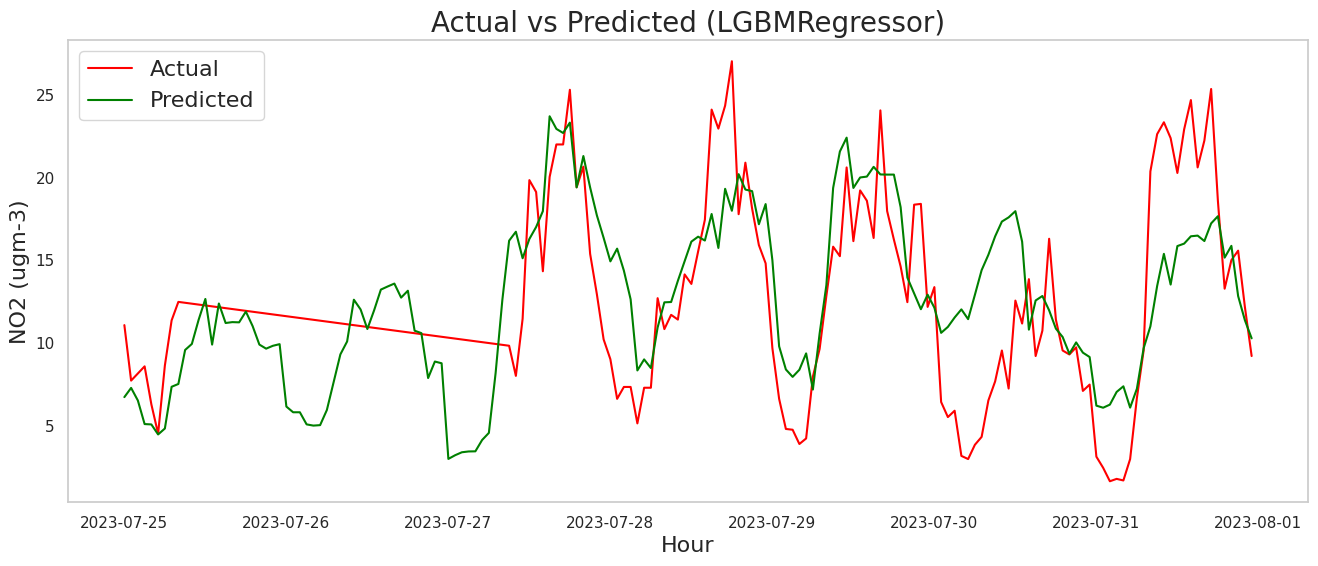

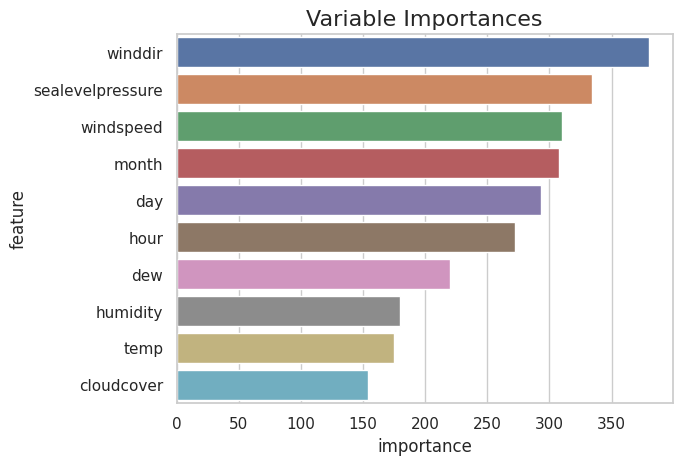

In [49]:
mae_reg, rmse_reg, predictions_reg, LGBM_model = train_LGBMRegressor(X, X_train, X_test, y_train, y_test)

In [50]:
print(f'LGBMRegressor Mean Absolute Error (MAE): {mae_reg}')
print('')
print(f'LGBMRegressor Root Mean Square Error (RMSE): {rmse_reg}')
print('')
print(f'LGBMRegressor Predictions (Total count is {len(predictions_reg)}):')
predictions_reg

LGBMRegressor Mean Absolute Error (MAE): 3.5703613422707305

LGBMRegressor Root Mean Square Error (RMSE): 4.446193252208237

LGBMRegressor Predictions (Total count is 168):


array([ 6.7500698 ,  7.30532227,  6.54553793,  5.12321787,  5.10167818,
        4.49675319,  4.85498396,  7.37310709,  7.54277625,  9.59382987,
        9.95925784, 11.41225619, 12.67206493,  9.91932919, 12.39836302,
       11.22111266, 11.27457982, 11.26032895, 11.91086695, 11.03594208,
        9.91989258,  9.67380991,  9.84607954,  9.94528627,  6.17983506,
        5.83595982,  5.83595982,  5.10427023,  5.03110821,  5.05930984,
        5.97273835,  7.6444475 ,  9.32683997, 10.1072429 , 12.62628247,
       12.03677645, 10.85931685, 11.98866728, 13.23718015, 13.42366355,
       13.59964735, 12.75347329, 13.16885395, 10.75682602, 10.61107247,
        7.90053367,  8.89618821,  8.7917068 ,  3.02120446,  3.24346128,
        3.42197395,  3.47115504,  3.47911189,  4.16227491,  4.5919158 ,
        8.20610215, 12.62254983, 16.18807554, 16.72804119, 15.12807814,
       16.29208336, 17.0122711 , 17.97034689, 23.69429972, 22.93329676,
       22.68519216, 23.31302967, 19.40321409, 21.29544189, 19.40

### XGBoost Regressor Model

In [51]:
def train_XGBoostRegressor(X, X_train, X_test, y_train, y_test):

    # Train model
    XGBoost_model = XGBRegressor(random_state=1)
    XGBoost_model.fit(X_train, y_train)

    # Cross-Validation to get predictions
    predict = cross_val_predict(XGBoost_model, X_test, y_test, cv=5)

    # Plot actual vs predicted for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title("Actual vs Predicted (XGBoost Regressor)", fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predict, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('NO2 (ugm-3)', fontsize=16)
    plt.legend(labels=['Actual', 'Predicted'], fontsize=16)
    plt.grid()
    plt.show()

    # Create a dataframe with the variable importances of the model
    df_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': XGBoost_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importance.importance, y=df_importance.feature[:10], orient='h')
    plt.show()

    # Calculate Mean Absolute Error (MAE)
    # Cross-Validation to get negative mean absolute error
    neg_mae_scores = cross_val_score(XGBoost_model, X_test, y_test, cv=5, scoring='neg_mean_absolute_error').mean()
    # Convert negative MAE to Mean Absolute Error (MAE)
    mae = -neg_mae_scores

    # Calculate Root Mean Square Error (RMSE)
    # Cross-Validation to get negative mean squared error
    neg_mse_scores = cross_val_score(XGBoost_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean()
    # Convert negative MSE to Root Mean Square Error (RMSE)
    rmse = np.sqrt(-neg_mse_scores)

    return mae, rmse, predict, XGBoost_model

### Train and Predict using XGBoost Regressor Model

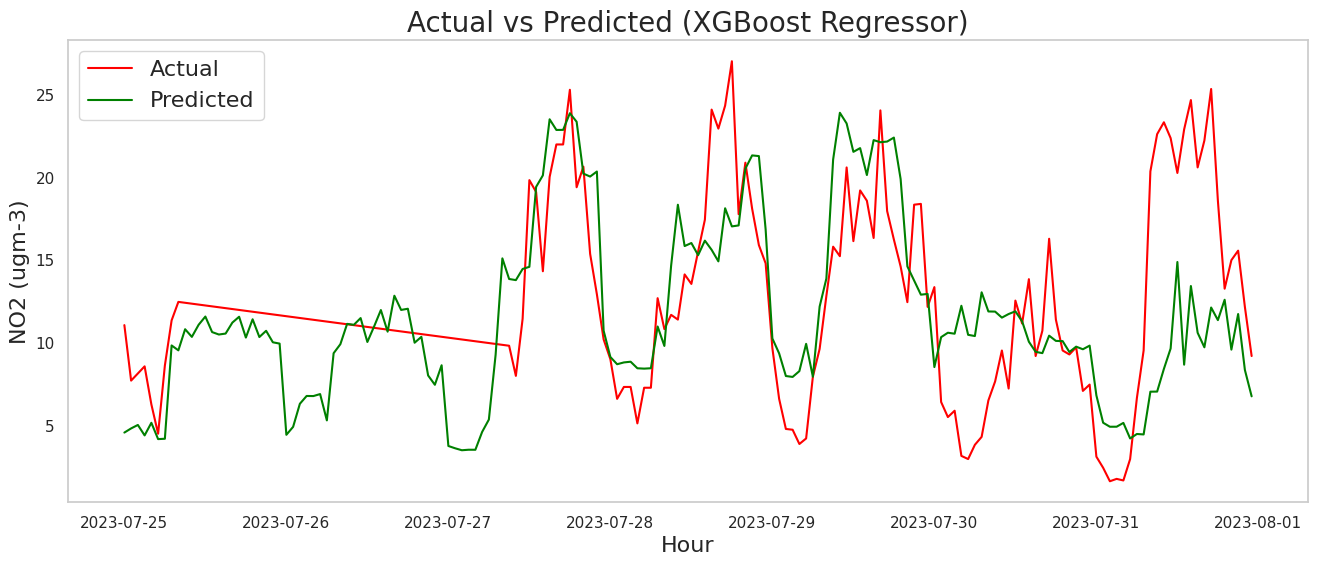

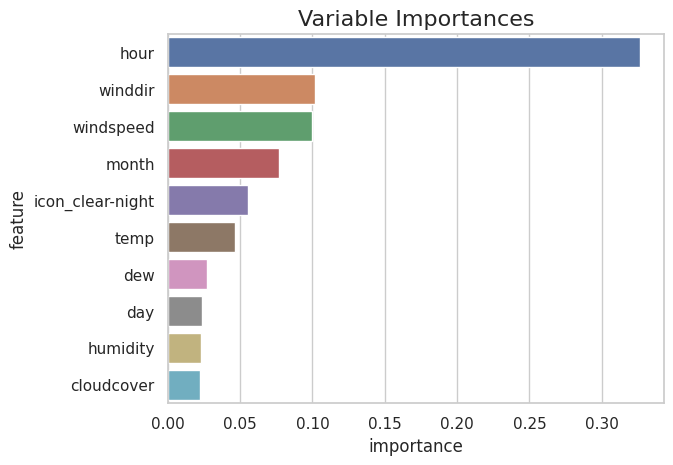

In [52]:
mae_XGBoost, rmse_XGBoost, predictions_XGBoost, XGBoost_model = train_XGBoostRegressor(X, X_train, X_test, y_train, y_test)

In [53]:
print(f'LGBMRegressor Mean Absolute Error (MAE): {mae_XGBoost}')
print('')
print(f'LGBMRegressor Root Mean Square Error (RMSE): {rmse_XGBoost}')
print('')
print(f'LGBMRegressor Predictions (Total count is {len(predictions_XGBoost)}):')
predictions_XGBoost

LGBMRegressor Mean Absolute Error (MAE): 3.679255470670384

LGBMRegressor Root Mean Square Error (RMSE): 4.9017566153328636

LGBMRegressor Predictions (Total count is 168):


array([ 4.6104083,  4.8613896,  5.07004  ,  4.4400043,  5.2005167,
        4.2165346,  4.236721 ,  9.867281 ,  9.571723 , 10.84579  ,
       10.384339 , 11.112997 , 11.611056 , 10.673494 , 10.526433 ,
       10.583346 , 11.245402 , 11.59823  , 10.342989 , 11.4454365,
       10.374387 , 10.750794 , 10.057016 ,  9.9784775,  4.4754395,
        4.955714 ,  6.3477693,  6.8188357,  6.8132358,  6.933275 ,
        5.344128 ,  9.397885 ,  9.942432 , 11.169191 , 11.112149 ,
       11.518576 , 10.076431 , 11.01404  , 12.003463 , 10.698859 ,
       12.866842 , 12.010064 , 12.081379 , 10.031634 , 10.386491 ,
        8.056565 ,  7.4936423,  8.672165 ,  3.801215 ,  3.6624696,
        3.5441275,  3.5751548,  3.5727973,  4.6473737,  5.396225 ,
        9.307205 , 15.121716 , 13.876862 , 13.808806 , 14.481691 ,
       14.611287 , 19.434576 , 20.129755 , 23.512596 , 22.869751 ,
       22.87392  , 23.878595 , 23.36332  , 20.234386 , 20.056526 ,
       20.360666 , 10.758175 ,  9.169728 ,  8.733809 ,  8.8425

### LSTM Model

In [54]:
def train_LSTM(df, horizon=24*7): # horizon is one week of hourly data

    # Set random state to ensure reproducibility of LSTM model
    random.seed(1)
    np.random.seed(1)
    tf.random.set_seed(1)

    # Extract the actual values for the last week
    y_true = df['NO2 (ugm-3)'].values[-horizon:]

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Normalize the data
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


    def create_sequences(data, seq_length):
        """
        Create sequences from the data.

        Parameters:
        - data: DataFrame containing the features
        - seq_length: length of the sequence

        Returns:
        - X: 3D numpy array containing the sequences
        - y: 1D numpy array containing the targets
        """
        X, y = [], []
        for i in range(len(data) - seq_length):
            seq = data.iloc[i:i+seq_length].values
            target = data['NO2 (ugm-3)'].iloc[i+seq_length]
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    # Define the sequence length
    seq_length = 24

    # Create sequences
    X, y = create_sequences(normalized_df, seq_length)


    # Splitting the data into training and testing sets
    X_train, X_test = X[:-horizon], X[-horizon:]
    y_train, y_test = y[:-horizon], y[-horizon:]

    X_train.shape, X_test.shape, y_train.shape, y_test.shape


    # Build the LSTM model
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(50, input_shape=(seq_length, X_train.shape[2])))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(optimizer='adam', loss='mse')

    # Train model
    LSTM_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=0)


    # Predict the NO2 concentration for the last week
    predictions = LSTM_model.predict(X_test)

    # Change normalized predictions to real number
    # Create a dummy DataFrame with the same structure as the normalized data
    dummy = pd.DataFrame(np.zeros((len(predictions), normalized_df.shape[1])), columns=normalized_df.columns)

    # Place the normalized predictions in the 'NO2 (ugm-3)' column
    dummy['NO2 (ugm-3)'] = predictions

    # Inverse transform the dummy DataFrame
    dummy_inverse = scaler.inverse_transform(dummy)

    # Extract the 'NO2 (ugm-3)' column, which now has the actual predictions
    actual_predictions = dummy_inverse[:, normalized_df.columns.get_loc('NO2 (ugm-3)')]


    # Plotting actual vs predicted for the last week of the dataset
    plt.figure(figsize=(16, 6))
    plt.title("Actual vs Predicted (LSTM)", fontsize=20)
    plt.plot(y_true, color='red')
    plt.plot(actual_predictions, color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('NO2 (ugm-3)', fontsize=16)
    plt.legend(labels=['Actual', 'Predicted'], fontsize=16)
    plt.grid()
    plt.show()


    # Calculate Mean Absolute Error (MAE)
    mae = np.round(mean_absolute_error(y_true, actual_predictions), 3)

    # Calculate Root Mean Square Error (RMSE)
    rmse = np.round(np.sqrt(mean_squared_error(y_true, actual_predictions)), 3)

    return mae, rmse, actual_predictions, LSTM_model

### Train and Predict using LSTM Model

6/6 [==============================] - 0s 5ms/step


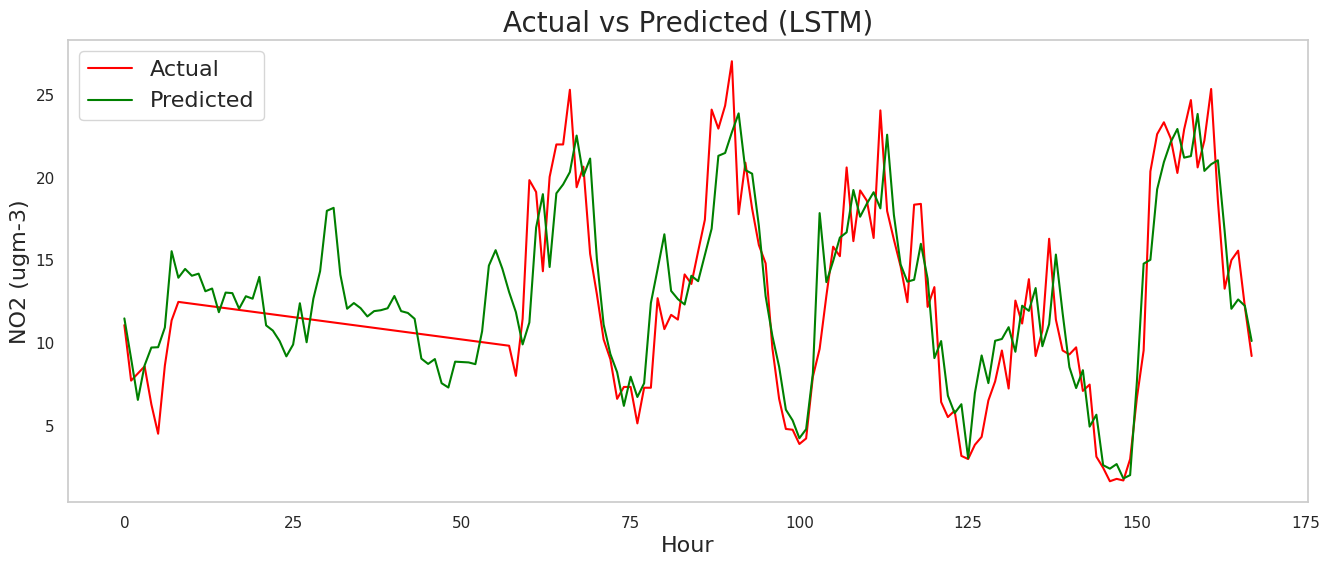

In [55]:
mae_lstm, rmse_lstm, predictions_lstm, LSTM_model = train_LSTM(merged_df)

In [56]:
print(f'LSTM Mean Absolute Error (MAE): {mae_lstm}')
print('')
print(f'LSTM Root Mean Square Error (RMSE): {rmse_lstm}')
print('')
print(f'LSTM Predictions (Total count is {len(predictions_lstm)}):')
predictions_lstm

LSTM Mean Absolute Error (MAE): 2.24

LSTM Root Mean Square Error (RMSE): 2.847

LSTM Predictions (Total count is 168):


array([11.49817367,  9.0731636 ,  6.58103448,  8.66703094,  9.74104897,
        9.76037991, 10.94997233, 15.5525308 , 13.95278064, 14.4831849 ,
       14.07246856, 14.1987589 , 13.13626836, 13.30146574, 11.87289007,
       13.0564278 , 13.02339779, 12.08359691, 12.83586542, 12.6879841 ,
       14.00517029, 11.07765764, 10.76325148, 10.13457106,  9.20862752,
        9.9205343 , 12.41239963, 10.06016994, 12.68987794, 14.35189035,
       17.98919482, 18.16856842, 14.135104  , 12.08276598, 12.42526933,
       12.11513342, 11.61691738, 11.93782822, 11.99320176, 12.11010284,
       12.85004629, 11.93772115, 11.8277406 , 11.47442896,  9.07137217,
        8.75199518,  9.04528209,  7.58869224,  7.32874412,  8.88860425,
        8.8662196 ,  8.84283721,  8.73762189, 10.72501246, 14.68358698,
       15.61599484, 14.49335156, 13.08610229, 11.87930087,  9.9299096 ,
       11.25339564, 16.98275591, 18.99461427, 14.59968564, 19.04414106,
       19.58227737, 20.32573772, 22.53095194, 20.0859057 , 21.14

For traditional machine learning models like decision trees, random forests, and gradient boosting machines, getting feature importances is straightforward. However, for deep learning models like LSTMs, extracting "feature importances" isn't as direct. Thus no future importance is provided for this model

# Ensemble Prediction Using SKlearn VotingRegressor (Hard Voting)

In [73]:
def train_ensemble(X, X_train, X_test, y_train, y_test):

    # Load base models
    rf_model = RandomForestRegressor(random_state=10)
    LGBM_model = LGBMRegressor(random_state=10, verbose=-1)
    XGBoost_model = XGBRegressor(random_state=10)

    # Load and train the ensemble model
    voting_ensemble = VotingRegressor([('reg1', rf_model), ('reg2', LGBM_model), ('reg3', XGBoost_model)])
    voting_ensemble.fit(X_train, y_train)

    # Cross-Validation to get predictions
    predict = cross_val_predict(voting_ensemble, X_test, y_test, cv=5)

    # Plot actual vs predicted for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title("Actual vs Predicted (Ensemble)", fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predict, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('NO2 (ugm-3)', fontsize=16)
    plt.legend(labels=['Actual', 'Predicted'], fontsize=16)
    plt.grid()
    plt.show()

    # Calculate Mean Absolute Error (MAE)
    # Cross-Validation to get negative mean absolute error
    neg_mae_scores = cross_val_score(voting_ensemble, X_test, y_test, cv=5, scoring='neg_mean_absolute_error').mean()
    # Convert negative MAE to Mean Absolute Error (MAE)
    mae = -neg_mae_scores

    # Calculate Root Mean Square Error (RMSE)
    # Cross-Validation to get negative mean squared error
    neg_mse_scores = cross_val_score(voting_ensemble, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean()
    # Convert negative MSE to Root Mean Square Error (RMSE)
    rmse = np.sqrt(-neg_mse_scores)

    return mae, rmse, predict

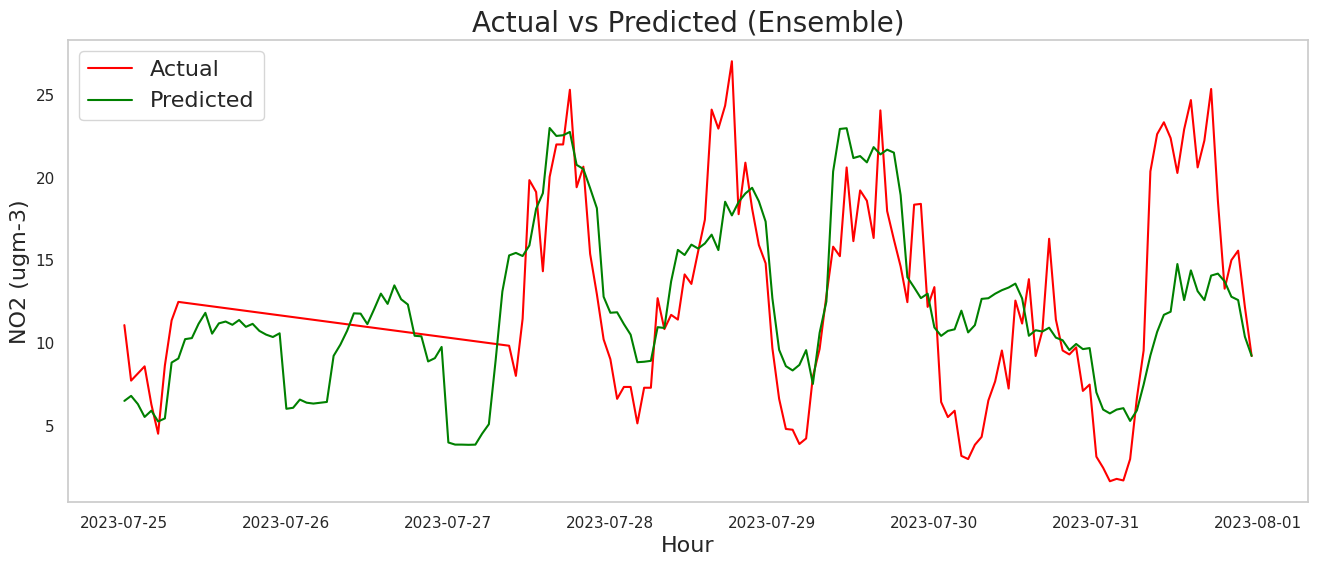

In [74]:
mae_avg_ensemble, rmse_avg_ensemble, predictions_avg_ensemble = train_ensemble(X, X_train, X_test, y_train, y_test)

In [75]:
print(f'Ensemble Mean Absolute Error (MAE): {mae_avg_ensemble}')
print('')
print(f'Ensemble Root Mean Square Error (RMSE): {rmse_avg_ensemble}')
print('')
print(f'Ensemble Predictions (Total count is {len(predictions_avg_ensemble)}):')
predictions_avg_ensemble

Ensemble Mean Absolute Error (MAE): 3.404708967122289

Ensemble Root Mean Square Error (RMSE): 4.3590281761371115

Ensemble Predictions (Total count is 168):


array([ 6.5217548 ,  6.82456212,  6.32931625,  5.55290746,  5.93341912,
        5.28149505,  5.46419474,  8.83423838,  9.07972938, 10.24633312,
       10.3116138 , 11.17690662, 11.83474848, 10.57898854, 11.19926665,
       11.3089797 , 11.11280693, 11.40083552, 10.99000919, 11.170036  ,
       10.74576761, 10.52053899, 10.37616345, 10.59961723,  6.04541591,
        6.10584844,  6.60087753,  6.41365998,  6.36014739,  6.41035789,
        6.45787508,  9.23991787,  9.91527934, 10.75287077, 11.80407418,
       11.78521583, 11.15316415, 12.05271969, 12.99496369, 12.37420005,
       13.49186862, 12.65319352, 12.33613677, 10.45067447, 10.41851977,
        8.90141531,  9.10089186,  9.7770888 ,  4.01196523,  3.88488977,
        3.8835904 ,  3.87175784,  3.88254923,  4.54528106,  5.11565553,
        8.95912139, 13.12372029, 15.29875062, 15.45175974, 15.26126107,
       15.89821453, 18.11881831, 19.05272197, 22.98703518, 22.50792965,
       22.5507709 , 22.74941674, 20.76327056, 20.51248308, 19.35

## Plots

### Plot of Actual vs All Models

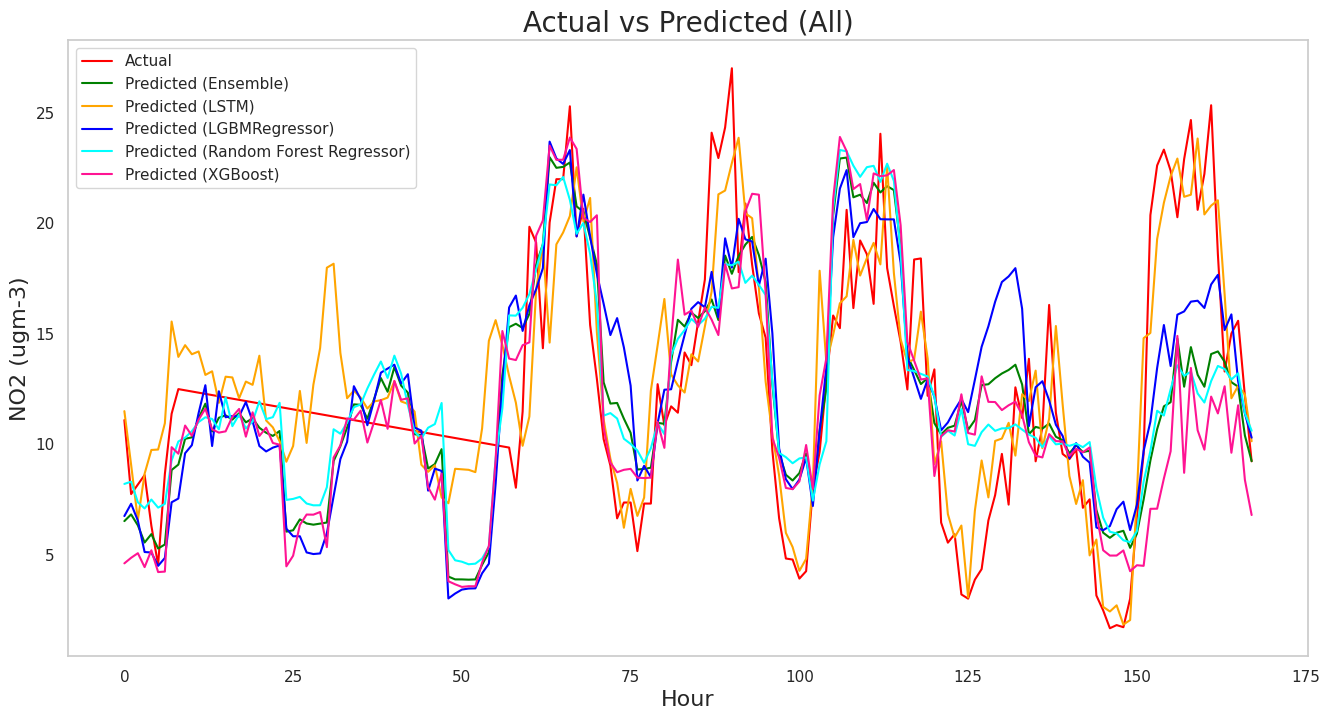

In [76]:
# Extract the actual values for the last week
horizon=24*7 # horizon is one week of hourly data
y_true = merged_df['NO2 (ugm-3)'].values[-horizon:]


# Plotting actual vs predicted for the last week of the dataset
plt.figure(figsize=(16, 8))
plt.title("Actual vs Predicted (All)", fontsize=20)
plt.plot(y_true, color='red')
plt.plot(predictions_avg_ensemble, color='green')
plt.plot(predictions_lstm, color='orange')
plt.plot(predictions_reg, color='blue')
plt.plot(predictions_randforest, color='cyan')
plt.plot(predictions_XGBoost, color='deeppink')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('NO2 (ugm-3)', fontsize=16)
plt.legend(labels=['Actual', 'Predicted (Ensemble)', 'Predicted (LSTM)', 'Predicted (LGBMRegressor)', 'Predicted (Random Forest Regressor)', 'Predicted (XGBoost)'])
plt.grid()
plt.show()

### Plot  of Mean Square Error (MSE) Perforance Metric  for all Models

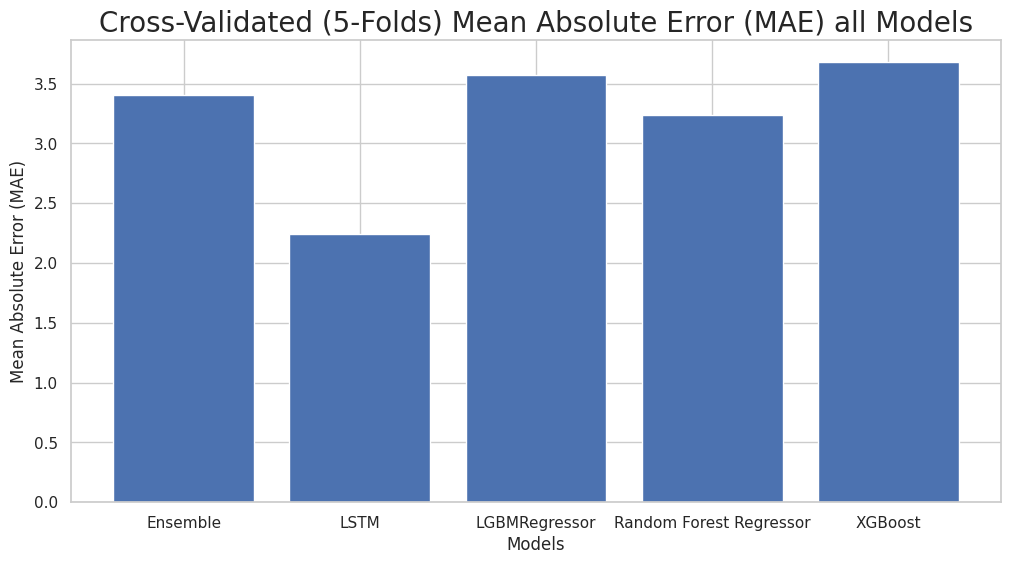

In [77]:
# Data
labels = ['Ensemble', 'LSTM', 'LGBMRegressor', 'Random Forest Regressor', 'XGBoost']
values = [mae_avg_ensemble, mae_lstm, mae_reg, mae_randforest, mae_XGBoost]

# Create Bar Chart
plt.figure(figsize=(12, 6))
plt.title('Cross-Validated (5-Folds) Mean Absolute Error (MAE) all Models', fontsize=20)
plt.bar(labels, values)
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')


# Show the chart
plt.show()

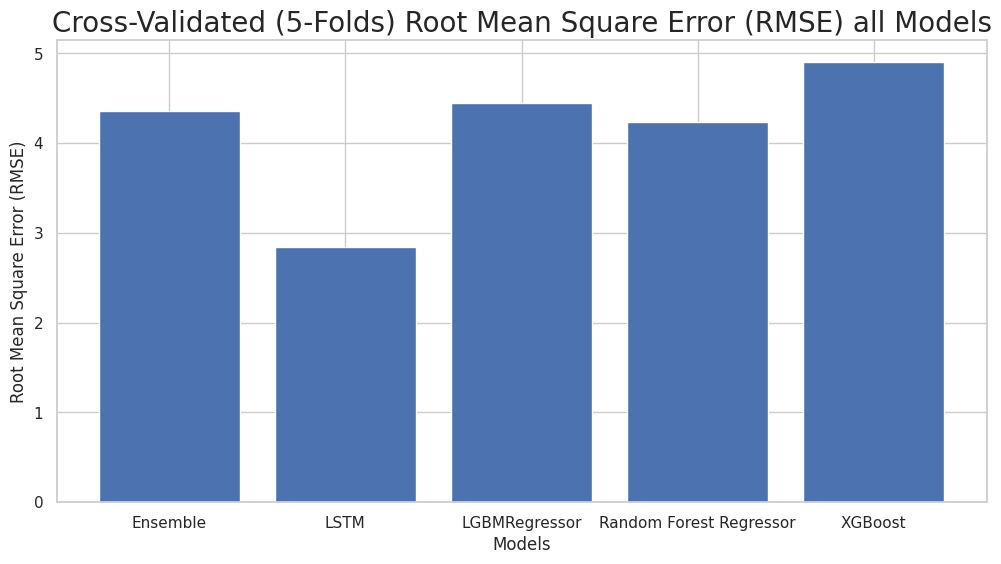

In [78]:
# Data
labels = ['Ensemble', 'LSTM', 'LGBMRegressor', 'Random Forest Regressor', 'XGBoost']
values = [rmse_avg_ensemble, rmse_lstm, rmse_reg, rmse_randforest, rmse_XGBoost]

# Create Bar Chart
plt.figure(figsize=(12, 6))
plt.title('Cross-Validated (5-Folds) Root Mean Square Error (RMSE) all Models', fontsize=20)
plt.bar(labels, values)
plt.xlabel('Models')
plt.ylabel('Root Mean Square Error (RMSE)')


# Show the chart
plt.show()